# Jankbench benchmark on Android

Most devices today refresh their screens 60 times a second. If there’s an animation or transition running, or the user is scrolling, applications need to match the device’s refresh rate and put up a new picture, or frame, for each of those screen refreshes.
When one fails to meet this budget - 16.6 ms, the frame rate drops, and the content judders on screen. This is often referred to as jank, and it negatively impacts the user's experience.

This benchmark is used to count the jank frames for different types of activities: list and image list view fling, text render, text editing, etc. Also **ftraces** are captured during the benchmark run and represented at the end of the notebook.

In [1]:
from conf import LisaLogging
LisaLogging.setup()

2017-08-24 09:59:07,262 INFO    : root         : Using LISA logging configuration:
2017-08-24 09:59:07,263 INFO    : root         :   /home/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')
    
    # Get workload
    wload = Workload.getInstance(te, 'Jankbench')
    
    # Run Jankbench workload
    wload.run(te.res_dir, test_name='list_view', iterations=1, collect='ftrace')
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
#     "platform"     : 'android',
#     "board"        : 'pixel',
    
#     # Device
#     "device"       : "FA6A10306347",
    
#     # Android home
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },
    
    # Folder where all the results will be collected
    "results_dir" : "Jankbench_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2017-08-24 09:59:13,459 INFO    : TestEnv      : Using base path: /home/lisa/lisa-github
2017-08-24 09:59:13,461 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-08-24 09:59:13,463 INFO    : TestEnv      : External tools using:
2017-08-24 09:59:13,464 INFO    : TestEnv      :    ANDROID_HOME: /home/lisa/android-sdk
2017-08-24 09:59:13,465 INFO    : TestEnv      :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-08-24 09:59:13,467 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-08-24 09:59:13,468 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-08-24 09:59:13,469 INFO    : TestEnv      : Connection settings:
2017-08-24 09:59:13,470 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-08-24 09:59:14,067 INFO    : TestEnv      : Initializing target workdir:
2017-08-24 09:59:14,069 INFO    : TestEnv      :    /data/local/tmp/devlib-target
2017-08-24 09:59:15,695 INFO    : TestEnv  

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Jankbench - list view fling** experiment.

In [6]:
# Intialize Workloads for this test environment
results = experiment()

2017-08-24 09:59:19,259 INFO    : Workload     : Packages:
['com.android.cts.priv.ctsshim', 'com.android.providers.telephony', 'com.android.providers.calendar', 'com.android.providers.media', 'com.android.wallpapercropper', 'com.android.launcher', 'com.antutu.ABenchMark', 'com.android.documentsui', 'com.android.externalstorage', 'com.android.htmlviewer', 'com.android.quicksearchbox', 'com.android.mms.service', 'com.android.providers.downloads', 'com.primatelabs.geekbench', 'com.antutu.benchmark.full', 'com.android.defcontainer', 'com.android.providers.downloads.ui', 'com.android.pacprocessor', 'com.android.certinstaller', 'android', 'com.android.contacts', 'com.android.camera2', 'com.android.egg', 'com.android.mtp', 'com.android.backupconfirm', 'com.android.provision', 'com.android.statementservice', 'com.android.calendar', 'com.android.providers.settings', 'com.android.sharedstoragebackup', 'com.android.printspooler', 'com.android.dreams.basic', 'com.android.webview', 'com.android.inp

2017-08-24 09:59:58,934 INFO    : Jankbench    :    Mean:  20.094 JankP:   0.820 StdDev:  19.386 Count Bad:  231 Count Jank:   13
2017-08-24 10:00:00,153 INFO    : Jankbench    : FTrace STOP


CalledProcessError: Command 'adb -s 0123456789ABCDEF pull '/data/data/com.android.benchmark/databases/BenchmarkResults' '/home/lisa/lisa-github/results/Jankbench_example/BenchmarkResults'' returned non-zero exit status 1

## Results collection

In [7]:
def import_db(path):
    # Selection of columns of interest
    COLS = ['_id', 'name', 'run_id', 'iteration', 'total_duration', 'jank_frame']
    data = []
    db = '{}/{}'.format(te.res_dir, 'BenchmarkResults')
    conn = sqlite3.connect(db)
    for row in conn.execute('SELECT {} FROM ui_results'.format(','.join(COLS))):
        row = ('sched', ) + row
        data.append(row)
    print "DB[ {} ]: {:6d} rows imported".format('sched', len(data))
    return pd.DataFrame(data, columns=['test', ] + COLS)

df = import_db(te.res_dir)

OperationalError: no such table: ui_results

## Benchmark plots and statistics

All the plots below represent total duration statistics for all the frames, in different ways.

In [8]:
def overall_statistics(df):
    byname_test = df.groupby(['name','test']).total_duration.describe(percentiles=[0.9, 0.95, 0.99])
    stats = pd.DataFrame(byname_test)
    stats = stats.unstack()
    return stats

stats = overall_statistics(df)
stats

NameError: name 'df' is not defined

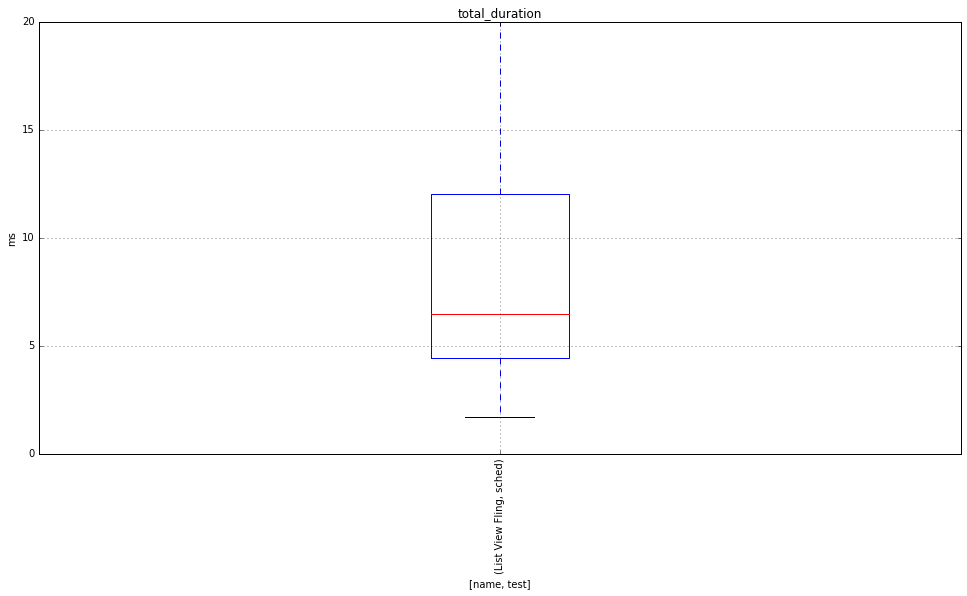

In [9]:
def total_duration_plot(data):
    fig, axes = plt.subplots(figsize=(16,8))
    bp = data.boxplot(by=['name','test'], column='total_duration', ax=axes, return_type='dict')
    fig.suptitle('')
    xlabels = [item.get_text() for item in axes.xaxis.get_ticklabels()]
    axes.set_xticklabels(xlabels, rotation=90)
    axes.set_ylim(0,20)
    axes.set_ylabel('ms');

total_duration_plot(data = df)

[1.01, 1.01]
[1.02, 1.02]
[1.03, 1.03]
[1.04, 1.04]
[1.05, 1.05]
[1.06, 1.06]
[1.07, 1.07]
[1.08, 1.08]
[1.09, 1.09]
[1.1, 1.1]
[1.11, 1.11]
[1.12, 1.12]
[1.1300000000000001, 1.1300000000000001]
[1.1400000000000001, 1.1400000000000001]
[1.1500000000000001, 1.1500000000000001]
[1.1600000000000001, 1.1600000000000001]
[1.1700000000000002, 1.1700000000000002]
[1.1800000000000002, 1.1800000000000002]
[1.1900000000000002, 1.1900000000000002]
[1.2000000000000002, 1.2000000000000002]
[1.2100000000000002, 1.2100000000000002]
[1.2200000000000002, 1.2200000000000002]
[1.2300000000000002, 1.2300000000000002]
[1.2400000000000002, 1.2400000000000002]
[1.2500000000000002, 1.2500000000000002]
[1.2600000000000002, 1.2600000000000002]
[1.2700000000000002, 1.2700000000000002]
[1.2800000000000002, 1.2800000000000002]
[1.2900000000000003, 1.2900000000000003]
[1.3000000000000003, 1.3000000000000003]
[1.3100000000000003, 1.3100000000000003]
[1.3200000000000003, 1.3200000000000003]
[1.3300000000000003, 1.330

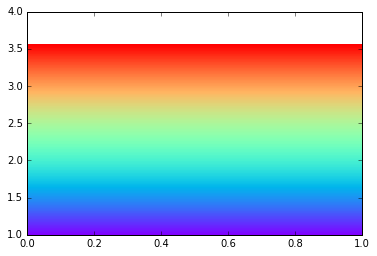

In [10]:
X = [1,1]

colors = iter(cm.rainbow(np.linspace(0, 1, 256)))
for i in range(256):
    for index, item in enumerate(X) :
        X[index] = item + 0.01
    print X
    plt.plot(X,color=next(colors))


In [9]:
def total_duration_cumulative_distribution(df):
    fig, axes = plt.subplots()
    plt.axhline(y=16, linewidth=2, color='r', linestyle='--')
    colors = iter(cm.rainbow(np.linspace(0, 1, 1)))
    df = pd.DataFrame(sorted(df.total_duration))
    df.plot(
        figsize=(16,8),
        ax=axes,
        color='b',
        linewidth=2,
        ylim=(0,80),
        legend=False);

    plt.legend(('16ms',) + tuple(['sched']), loc='best');
    
total_duration_cumulative_distribution(df)

NameError: name 'df' is not defined

## Traces - Latency analysis

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [10]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2017-08-24 10:04:09,642 INFO    : Trace        : Platform clusters verified to be Frequency coherent
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


2017-08-24 10:05:07,389 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-08-24 10:05:07,391 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-08-24 10:05:07,393 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-08-24 10:05:07,421 INFO    : Analysis     : Parsing sched_switch states assuming kernel v4.4
2017-08-24 10:05:07,915 INFO    : Analysis     : Found:  3283 WAKEUP latencies
2017-08-24 10:05:07,973 INFO    : Analysis     : Found:   165 PREEMPT latencies
2017-08-24 10:05:07,975 INFO    : Analysis     : Total:  3448 latency events
2017-08-24 10:05:07,978 INFO    : Analysis     : 100.0 % samples below 1 [ms] threshold


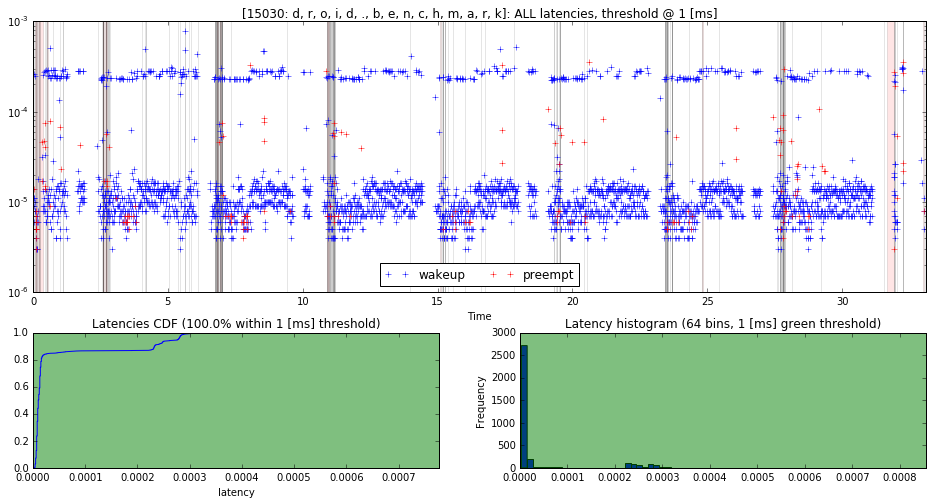

In [11]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('droid.benchmark')

2017-08-24 10:05:17,830 INFO    : Analysis     : LITTLE cluster average frequency: 1.138 GHz
2017-08-24 10:05:17,832 INFO    : Analysis     : big    cluster average frequency: 1.149 GHz


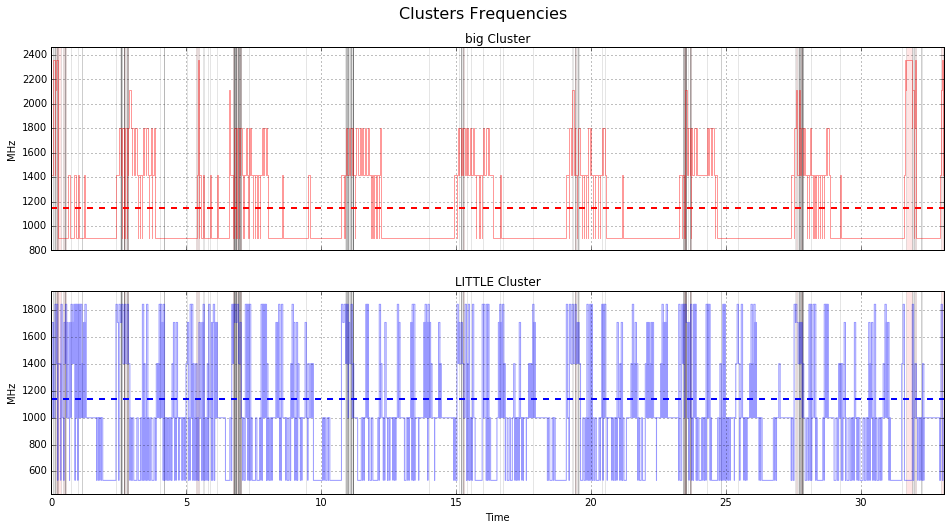

In [12]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass